# **Step 0 Import Required Packages**

In [1]:
import numpy as np
import scipy.io
import sklearn.metrics
import sklearn 
import os
import random
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pickle
from sklearn.preprocessing import StandardScaler
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout, BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

# **Step 1 Read The Files**

In [2]:
# When using Colab, you can upload train_set.zip in the content folder and run this kernel.
!unzip -qq /content/train_set.zip 

In [2]:
# Set your directory to read the data, default is the directory in colab.
unzipped_folder_path = 'C:/Users/wannian/Desktop/face/train_set'

In [3]:
def read_data(unzipped_folder_path):
  
  # read labels
  labels = pd.read_csv(unzipped_folder_path+'/label.csv')
  y= labels['label'].to_numpy()

  # read points
  n = 3000
  for i in range(1,n+1):
    p_path = str(i).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords = mat['faceCoordinatesUnwarped'] 
    else:
      cords = mat['faceCoordinates2']

    distance = sklearn.metrics.pairwise_distances(cords)       
          # compute the pairwise distances in each mat
    flatten_distance = distance[np.triu_indices(len(cords[:,0]), k = 1)]    
          # stretch the upper triangle of the symmetric matrix 
          # to a long array with dimension 3003
          # 3003 = (1+77)*78/2
    if i==1:
      distances = np.mat([flatten_distance])
    else:
      distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
  return (distances, y)

In [4]:
read_time_start=time.time()
Ori_X, Ori_Y = read_data(unzipped_folder_path)
print("Read the original dataset takes %s seconds" % round((time.time() - read_time_start),3))

Read the original dataset takes 76.832 seconds


In [5]:
Ori_X.shape, Ori_Y.shape 
# should be (3000,3003) and (3000,) 
# which means 3000 number of cases 
# and 3003 numbers of pairwise distances
# of 78 fiducial points. 
# 3003 = (1+77)*78/2

((3000, 3003), (3000,))

# **Step 2 Data Preprocessing For the Imbalanced Dataset & Generate New Data to Improve Learning Accuracy** 
## From the following analysis, we found that the Original Dataset is unbalanced. So we decided to generate new data for the class with smaller number of original samples. By generating new data, we not only balanced the data with equal number of samples in different class, but also create new data to help improve the learning accuracy.

* Because the number of Class 1 samples is less than the number of Class 0 samples, we decided to add more data in Class 1.
* The way we generate more data is that we randomly select two original cordinates of fiducial points in Class 1 and average them to generate new data of fiducial points and then calculate its pairwise distances and give it the label of 1. 
* It would make sense cause our models believe that the fiducial points in the same class will generate similar distribution in pairwise distances.

In [27]:
# Analyzing the data
n = Ori_Y.shape[0]
print('The number of class 0 is ' + str(n-sum(Ori_Y)))
print('The number of class 1 is ' + str(sum(Ori_Y)))
print('Only %.2f'% (sum(Ori_Y)/n*100) + '% of total dataset are class 1. ')
print('So, it is an unbalanced dataset, we need to do some data preprocessing.')
print('Here, we are using oversampling to generate more class 1 datasets.')

The number of class 0 is 2402
The number of class 1 is 598
Only 19.93% of total dataset are class 1. 
So, it is an unbalanced dataset, we need to do some data preprocessing.
Here, we are using oversampling to generate more class 1 datasets.


In [6]:
def data_preprocessing(Ori_X, Ori_Y, unzipped_folder_path):

  # data preprocessing

  distances = Ori_X
  y = Ori_Y

  n = y.shape[0]
  mat_1 = np.add(np.where(y == 1),1)
  n_oversample = (n-sum(y))-sum(y) 
    # how many samples do we need to generate

  for i in range(n_oversample):
    samples_index = random.sample(list(list(mat_1)[0]), 2)
      # pick two random index of class 1 samples. 

    p_path = str(samples_index[0]).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords_0 = mat['faceCoordinatesUnwarped'] 
    else:
      cords_0 = mat['faceCoordinates2']
    
    p_path = str(samples_index[1]).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords_1 = mat['faceCoordinatesUnwarped'] 
    else:
      cords_1 = mat['faceCoordinates2']

    cords_new = (cords_0 + cords_1) / 2 
        # averaging two sets of cordinates to generate new set of cordinates
    distance = sklearn.metrics.pairwise_distances(cords_new)
        # compute the pairwise distances in each mat
    flatten_distance = distance[np.triu_indices(len(cords_new[:,0]), k = 1)]
        # stretch the upper triangle of the symmetric matrix 
        # to a long array with dimension 3003
        # 3003 = (1+77)*78/2
    
    distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
    y = np.append(y,np.array(1))
        # Append new data to the original dataset

  return (distances, y) 


In [7]:
Balanced_X, Blanced_Y = data_preprocessing(Ori_X, Ori_Y, unzipped_folder_path)

In [8]:
Balanced_X.shape, Blanced_Y.shape

((4804, 3003), (4804,))

# **Step 3 Baseline Model: GBM on Original Dataset**

## 1. Create train and test features and labels

In [9]:
#Create train and test features and labels from Balanced Data set
train_features, test_features, train_labels, test_labels = train_test_split(Ori_X,Ori_Y,test_size=0.2,random_state=42)
print(train_features.shape,test_features.shape,train_labels.shape,test_labels.shape)

(2400, 3003) (600, 3003) (2400,) (600,)


## 2. Train a GBM model using random parameters on original data set

In [10]:
gbm = GradientBoostingClassifier(learning_rate=0.1,max_depth=2,n_estimators=100) 
start_time=time.time()
gbm.fit(train_features, train_labels)
print("Training  model takes %s seconds" % round((time.time() - start_time),3))

Training  model takes 209.637 seconds


In [11]:
print('Accuracy of the GBM on test set: {:.3f}'.format(gbm.score(test_features,test_labels)))

start = time.time()
prediction = gbm.predict(test_features)
end = time.time()

predprob = gbm.predict_proba(test_features)[:,1]

print("Predicting test data takes %s seconds" % round((end - start),3))
print('Classification error rate:', np.mean(np.array(test_labels)!= prediction))
print('Classification report \n', classification_report(test_labels, prediction))

#Since the class distribution is imbalanced/ skewed, we should look at the confusion matrix and AUC
print('Confusion Matrix \n', confusion_matrix(test_labels, prediction))
print('AUC is: {:.4f}'.format(roc_auc_score(test_labels, predprob)))

Accuracy of the GBM on test set: 0.797
Predicting test data takes 0.014 seconds
Classification error rate: 0.20333333333333334
Classification report 
               precision    recall  f1-score   support

           0       0.80      0.98      0.88       461
           1       0.74      0.19      0.30       139

    accuracy                           0.80       600
   macro avg       0.77      0.58      0.59       600
weighted avg       0.79      0.80      0.75       600

Confusion Matrix 
 [[452   9]
 [113  26]]
AUC is: 0.7992


## 3.GBM Cross Validation and Parameter tuning

### 3.1 Cross Validation on GBM learning rate and max_depth

In [18]:
# param_grid = {'learning_rate':[0.05,0.1], 'max_depth': [1,2,3]}
# grid = GridSearchCV(GradientBoostingClassifier(),param_grid,refit=True,verbose=3)
# grid.fit(train_features,train_labels)

In [ ]:
# print(grid.best_params_)
# print(grid.best_estimator_)

best_params: {'learning_rate': 0.1, 'max_depth': 2}

### 3.2 CrossValidation on GBM with n_estimators

In [ ]:
# param_grid2 = {'n_estimators':[50,100,250,500]} 
# grid2 = GridSearchCV(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2),param_grid= param_grid2,refit=True,verbose=3)
# grid2.fit(train_features,train_labels)

In [ ]:
# print(grid2.best_params_)
# print(grid2.best_estimator_)
# grid2_predictions = grid2.predict(test_features)
# print(confusion_matrix(test_labels,grid2_predictions))
# print(classification_report(test_labels,grid2_predictions))

best_params: {'n_estimators': 500}

### 3.3 Best GBM Model
* Final Parameter for baseline GBM set at: learning_rate=0.1, n_estimators=500, max_depth=2

In [12]:
#Training baseline: GBM using best parameters found above through CV

gbm_best = GradientBoostingClassifier(learning_rate=0.1,max_depth=2,n_estimators=500) 
start_time=time.time()
gbm_best.fit(train_features, train_labels)
print("Training  model takes %s seconds" % round((time.time() - start_time),3))

Training  model takes 1058.803 seconds


### 3.4 Evaluate BGM Model

In [13]:
print('Accuracy of the GBM on test set: {:.3f}'.format(gbm_best.score(test_features,test_labels)))

start = time.time()
baseline_pred = gbm_best.predict(test_features)
end = time.time()

baseline_predprob = gbm_best.predict_proba(test_features)[:,1]

print("Predicting test data takes %s seconds" % round((end - start),3))
print('Classification error rate:', np.mean(np.array(test_labels)!= baseline_pred))
print('Classification report \n', classification_report(test_labels, baseline_pred))

#Since the class distribution is imbalanced/ skewed, we should look at the confusion matrix and AUC
print('Confusion Matrix \n', confusion_matrix(test_labels, baseline_pred))
print('AUC is: {:.4f}'.format(roc_auc_score(test_labels, baseline_predprob)))

Accuracy of the GBM on test set: 0.817
Predicting test data takes 0.031 seconds
Classification error rate: 0.18333333333333332
Classification report 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       461
           1       0.71      0.35      0.47       139

    accuracy                           0.82       600
   macro avg       0.77      0.65      0.68       600
weighted avg       0.80      0.82      0.79       600

Confusion Matrix 
 [[441  20]
 [ 90  49]]
AUC is: 0.8091


Cross validation improved accuracy from 0.797 to 0.82, and AUC from 0.797 to 0.81

### 3.5 Save The Model

In [16]:
# Save best gbm model
save_weights_path = '../data/baseline_gbm.p'
pickle.dump(gbm_best, open(save_weights_path,'wb'))

# **Step 4 Advanced Model -- Densely Connected Neural Network**
* Based on the paper [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993) ,  Desely Connected Convolutional Neural Networks is a good model for image classification. With the improved data -- fiducial points, we will get a better accuracy and auc.

### 4.1 Data Scaling On Balanced Dataset And Train Test Split

In [17]:
scaler = StandardScaler()
scaler.fit(Balanced_X)
distances_scale = scaler.transform(Balanced_X)

In [18]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(distances_scale, Blanced_Y, random_state=123)

In [19]:
one_hot_test=tf.one_hot(y_test,depth=2)
one_hot_train=tf.one_hot(y_train,depth=2)

### 4.2 Build The Architecture Of The Model

In [20]:
model = tf.keras.Sequential([
        Input([3003]),
        BatchNormalization(),
        Dense(600,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dropout(0.25),
        BatchNormalization(),
        Dense(300,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dropout(0.25),
        Dense(150,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dropout(0.25),
        Dense(50,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4)),
        Dense(2,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=4))
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3003)              12012     
_________________________________________________________________
dense (Dense)                (None, 600)               1802400   
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               4

In [22]:
start_time = time.time()
model.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_history = model.fit(X_train,one_hot_train,epochs = 80)
print("training  model takes %s seconds" % round((time.time() - start_time),3))

Epoch 1/80
113/113 [==============================] - 2s 22ms/step - loss: 0.6719 - accuracy: 0.6370
Epoch 2/80
113/113 [==============================] - 3s 24ms/step - loss: 0.5611 - accuracy: 0.7089
Epoch 3/80
113/113 [==============================] - 3s 23ms/step - loss: 0.5122 - accuracy: 0.7513
Epoch 4/80
113/113 [==============================] - 3s 27ms/step - loss: 0.4804 - accuracy: 0.7688
Epoch 5/80
113/113 [==============================] - 3s 28ms/step - loss: 0.4367 - accuracy: 0.8018
Epoch 6/80
113/113 [==============================] - 3s 27ms/step - loss: 0.4104 - accuracy: 0.8088
Epoch 7/80
113/113 [==============================] - 3s 29ms/step - loss: 0.4061 - accuracy: 0.8099
Epoch 8/80
113/113 [==============================] - 3s 29ms/step - loss: 0.3924 - accuracy: 0.8152
Epoch 9/80
113/113 [==============================] - 3s 29ms/step - loss: 0.3756 - accuracy: 0.8204
Epoch 10/80
113/113 [==============================] - 3s 28ms/step - loss: 0.3596 - accura

### 4.3 Visualize The Training Process

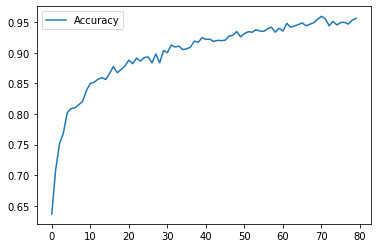

In [23]:
his_plot = pd.DataFrame(model_history.history)
plt.plot(his_plot['accuracy'],label = 'Accuracy')
plt.legend()

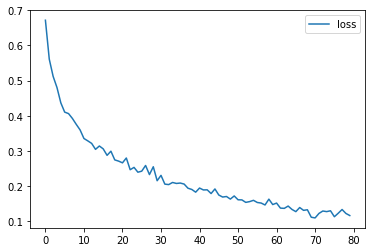

In [24]:
plt.plot(his_plot['loss'],label = 'loss')
plt.legend()

### 4.4 Evaluate The Model On Test Accuracy and AUC

In [25]:
# Test on the balanced dataset
start_time = time.time()
y_fitprob = model.predict(X_train)
y_fit = np.argmax(y_fitprob, axis=-1)
print("Testing model on train_dataset takes %s seconds" % round((time.time() - start_time),3))

start_time = time.time()
y_predprob = model.predict(X_test)
y_pred = np.argmax(y_predprob, axis=-1)
print("Testing model on test_dataset takes %s seconds" % round((time.time() - start_time),3))

print("Train dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(y_train, y_fit))
print("Train dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(one_hot_train, y_fitprob))
print("Test dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(y_test,y_pred))
print("Test dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(one_hot_test, y_predprob))

Testing model on train_dataset takes 0.693 seconds
Testing model on test_dataset takes 0.211 seconds
Train dataset -- Accuracy:  0.98
Train dataset -- AUC:  1.00
Test dataset -- Accuracy:  0.89
Test dataset -- AUC:  0.97


In [26]:
# Test on the original dataset

scaler = StandardScaler()
scaler.fit(Ori_X)
ori_scale = scaler.transform(Ori_X)
one_hot_o = tf.one_hot(Ori_Y,depth=2)

start_time = time.time()
y_fitprob_o = model.predict(ori_scale)
y_fit = np.argmax(y_fitprob_o, axis=-1)
print("Testing model on original dataset takes %s seconds" % round((time.time() - start_time),3))

print("Train dataset -- Accuracy:  %.2f" % sklearn.metrics.accuracy_score(Ori_Y, y_fit))
print("Train dataset -- AUC:  %.2f" % sklearn.metrics.roc_auc_score(one_hot_o, y_fitprob_o))

Testing model on original dataset takes 0.461 seconds
Train dataset -- Accuracy:  0.87
Train dataset -- AUC:  0.98


We can see that the model have 0.9-0.91 Test Auccuracy and 0.97-0.98 AUC. It can generalize well.

### 4.5 Save The Model

In [27]:
# Save the model
model.save("DNN")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: DNN\assets


# **Step 5 Predict Test Data**
* If you skip the previous steps and want to predict test data immediately, please import the required dataset.

In [ ]:
import numpy as np
import scipy.io
import sklearn.metrics
import sklearn 
import os
import random
import pandas as pd
import time
import pickle
from sklearn.preprocessing import StandardScaler
import keras.models
import tensorflow as tf

* Run the function to read the test dataset

In [ ]:
def read_test_data(unzipped_folder_path,n):

  # read points
  for i in range(1,n+1):
    p_path = str(i).zfill(4)+'.mat'
    mat = scipy.io.loadmat(unzipped_folder_path+'/points/'+p_path)
    if 'faceCoordinatesUnwarped' in mat:
      cords = mat['faceCoordinatesUnwarped'] 
    else:
      cords = mat['faceCoordinates2']

    distance = sklearn.metrics.pairwise_distances(cords)       
          # compute the pairwise distances in each mat
    flatten_distance = distance[np.triu_indices(len(cords[:,0]), k = 1)]    
          # stretch the upper triangle of the symmetric matrix 
          # to a long array with dimension 3003
          # 3003 = (1+77)*78/2
    if i==1:
      distances = np.mat([flatten_distance])
    else:
      distances = np.append(distances, np.mat([flatten_distance]), axis = 0)
  return (distances)


* Set path to the unfolded test dataset and path to where you want to store the output csv file.

In [ ]:
test_data_path = ''
output_labels_path = ''
save_weights_path = '../data/output/baseline_gbm.p'

* Read the data

In [ ]:
start_time = time.time()
test_distances = read_test_data(test_data_path,n)
print("Read the training dataset takes %s seconds" % round((time.time() - start_time),3))

* Scale the data

In [ ]:
# Scale the input distances
scaler = StandardScaler()
scaler.fit(test_distances)
test_distances_scale = scaler.transform(test_distances)

* Load the model

In [ ]:
# Load DNN model
predict_model = keras.models.load_model("DNN")
# Load gbm model
predict_model_baseline=pickle.load(open(save_weights_path,'rb'))

 * Predict the labels

In [ ]:
start_time = time.time()
test_predprob = predict_model.predict(test_distances_scale)
test_classes = np.argmax(test_predprob, axis=-1)
print("Testing model on test dataset takes %s seconds" % round((time.time() - start_time),3))

* Write the labels to csv

In [ ]:
test_labels_pd = pd.DataFrame(test_classes) 
test_labels_pd.to_csv(output_labels_path)